<a href="https://colab.research.google.com/github/ameroyer/advent_of_code_2018/blob/master/day6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ☃️ [Day 6](https://adventofcode.com/2018/day/6)

In [0]:
import numpy as np

def get_dists(inputs, offset=None, limit=False):
  xmin = np.amin(inputs[:, 0])
  ymin = np.amin(inputs[:, 1])
  xmax = np.amax(inputs[:, 0])
  ymax = np.amax(inputs[:, 1])
  if offset is not None:
    if not limit: # fixed offset
      xmin -= offset
      ymin -= offset
      xmax += offset
      ymax += offset
    else:         # all points are in the limit
      offset = offset - (xmax - xmin) - (ymax - ymin) 
      xmin -= offset 
      ymin -= offset
      xmax += offset 
      ymax += offset      
  canvas = np.meshgrid(np.arange(xmin, xmax + 1), np.arange(ymin, ymax + 1))
  canvas = np.stack(canvas, axis=-1)
  dists = np.sum(np.abs(canvas[None, :, :, :] - inputs[:, None, None, :]), axis=-1)
  return xmin, ymin, xmax, ymax, dists

def get_infinite_regions(inputs):
  def process_diffs(diffs):
    np.fill_diagonal(diffs, True)
    return np.prod(diffs, axis=0) > 0  
  # Check if each region can be infinitely extend to the left / right / top /bottom
  left = process_diffs((inputs[None, :, 0] - inputs[:, None, 0]) < np.abs(inputs[None, :, 1] - inputs[:, None, 1]))
  right = process_diffs((inputs[:, None, 0] - inputs[None, :, 0]) < np.abs(inputs[None, :, 1] - inputs[:, None, 1]))
  top = process_diffs(np.abs(inputs[None, :, 0] - inputs[:, None, 0]) > (inputs[None, :, 1] - inputs[:, None, 1]))
  bottom = process_diffs(np.abs(inputs[None, :, 0] - inputs[:, None, 0]) > (inputs[:, None, 1] - inputs[None, :, 1]))
  infinite_regions = left + right + top + bottom
  return infinite_regions

def get_largest_finite_area(inputs):
  xmin, ymin, xmax, ymax, dists = get_dists(inputs)
  # Compute regions while removing collisions
  dists = (dists == np.amin(dists, axis=0, keepdims=True)).astype(np.float32)
  dists[:, np.sum(dists, axis=0) > 1] = np.nan
  dists = np.nansum(dists, axis=(1, 2)).astype(np.float32)
  # Ignore points with infinite area
  dists[get_infinite_regions(inputs) == True] = np.nan
  # Return
  return int(np.nanmax(dists))


def get_largest_close_to_all_area(inputs, offset=10000):
  canvas_offset = int(offset / inputs.shape[0]) # offset should be the min distance and we care about the sum
  _, _, _, _, dists = get_dists(inputs, offset=canvas_offset, limit=False)
  dists = np.sum(dists, axis=0)
  dists = dists < offset
  return np.sum(dists)

In [5]:
%%time
with open("day6.txt", 'r') as f:
  inputs = np.array([list(map(int, x.split(', '))) for x in f.read().splitlines()])
  
print('Largest Finite Area:', get_largest_finite_area(inputs))
print('Largest Close to all Area:', get_largest_close_to_all_area(inputs, offset=10000))

Largest Finite Area: 3687
Largest Close to all Area: 40134
CPU times: user 1.18 s, sys: 44.5 ms, total: 1.22 s
Wall time: 1.23 s


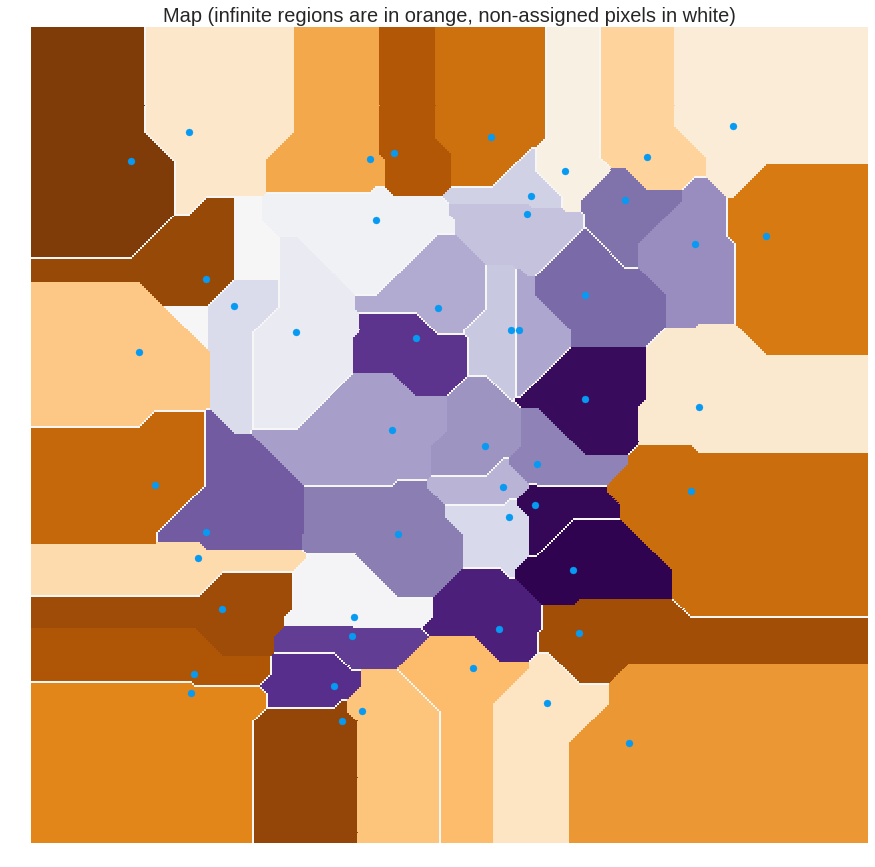

In [6]:
#@title Visualize the mesh 
from matplotlib import pyplot as plt
def visualize(inputs, offset=50):
  xmin, ymin, _, _, dists = get_dists(inputs, offset=offset)
  dists = (dists == np.amin(dists, axis=0, keepdims=True))
  num_points = inputs.shape[0]
  dists = (np.argmax(dists, axis=0) + 1) - (np.sum(dists, axis=0) > 1) * num_points
  # Plot non assigned region in white
  dists[dists <= 0] = 0
  # points with inifinite regions
  infinite_regions = get_infinite_regions(inputs)
  for k in np.where(infinite_regions == True)[0]:
    dists[dists == k + 1] *= -1
  # Display
  plt.figure(figsize=(15, 15))
  plt.pcolormesh(dists, cmap='PuOr', vmin=-num_points, vmax=num_points)
  plt.gca().invert_yaxis()
  plt.axis('off')
  plt.scatter(inputs[:, 0] - xmin, inputs[:, 1] - ymin, marker='o', c='xkcd:azure')  
  plt.title('Map (infinite regions are in orange, non-assigned pixels in white)', fontsize=20)
  
visualize(inputs)